In [1]:
%pip install cpprb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install bytecode
!python /home/regmed/dregmed/vis_to_nav/metrics_data/setup.py install

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
running install
error: can't create or remove files in install directory

The following error occurred while trying to add or remove files in the
installation directory:

    [Errno 13] Permission denied: '/usr/local/lib/python3.10/dist-packages/test-easy-install-15517.write-test'

The installation directory you specified (via --install-dir, --prefix, or
the distutils default setting) was:

    /usr/local/lib/python3.10/dist-packages/

Perhaps your account does not have write access to this directory?  If the
installation directory is a system-owned directory, you may need to sign in
as the administrator or "root" account.  If you do not have administrative
access to this machine, you may wish to choose a different installation
directory

In [ ]:
#@title visualizer
from bytecode import Bytecode, Instr
import torch
import torchvision.transforms as T
import json
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import math
import os
import numpy as np
import copy
class get_local(object):
    cache = {}
    is_activate = False

    def __init__(self, varname):
        self.varname = varname

    def __call__(self, func):
        if not type(self).is_activate:
            return func

        type(self).cache[func.__qualname__] = []
        c = Bytecode.from_code(func.__code__)
        extra_code = [
                         Instr('STORE_FAST', '_res'),
                         Instr('LOAD_FAST', self.varname),
                         Instr('STORE_FAST', '_value'),
                         Instr('LOAD_FAST', '_res'),
                         Instr('LOAD_FAST', '_value'),
                         Instr('BUILD_TUPLE', 2),
                         Instr('STORE_FAST', '_result_tuple'),
                         Instr('LOAD_FAST', '_result_tuple'),
                     ]
        c[-1:-1] = extra_code
        func.__code__ = c.to_code()

        def wrapper(*args, **kwargs):
            res, values = func(*args, **kwargs)
            type(self).cache[func.__qualname__].append(values.detach().cpu().numpy())
            return res
        return wrapper

    @classmethod
    def clear(cls):
        for key in cls.cache.keys():
            cls.cache[key] = []

    @classmethod
    def activate(cls):
        cls.is_activate = True
get_local.clear()
#visualizer function

get_local.activate()

# def grid_show(to_shows, cols):
#     rows = (len(to_shows)-1) // cols + 1
#     it = iter(to_shows)
#     fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
#     for i in range(rows):
#         for j in range(cols):
#             try:
#                 image, title = next(it)
#             except StopIteration:
#                 image = np.zeros_like(to_shows[0][0])
#                 title = 'pad'
#             axs[i, j].imshow(image)
#             axs[i, j].set_title(title)
#             axs[i, j].set_yticks([])
#             axs[i, j].set_xticks([])
#     plt.show()

# def visualize_head(att_map):
#     ax = plt.gca()
#     # Plot the heatmap
#     im = ax.imshow(att_map)
#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax)
#     plt.show()

# def visualize_heads(att_map, cols):
#     to_shows = []
#     att_map = att_map.squeeze()
#     for i in range(att_map.shape[0]):
#         to_shows.append((att_map[i], f'Head {i}'))
#     average_att_map = att_map.mean(axis=0)
#     to_shows.append((average_att_map, 'Head Average'))
#     grid_show(to_shows, cols=cols)

# def gray2rgb(image):
#     return np.repeat(image[...,np.newaxis],3,2)

# def cls_padding(image, mask, cls_weight, grid_size):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)

#     image = np.array(image)

#     H, W = image.shape[:2]
#     delta_H = int(H/grid_size[0])
#     delta_W = int(W/grid_size[1])

#     padding_w = delta_W
#     padding_h = H
#     padding = np.ones_like(image) * 255
#     padding = padding[:padding_h, :padding_w]

#     padded_image = np.hstack((padding,image))
#     padded_image = Image.fromarray(padded_image)
#     draw = ImageDraw.Draw(padded_image)
#     if padded_image.mode == 'L':
#         draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=0)  # Use grayscale fill color (0 for black)
#     else:
#         draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0))  # Use RGB fill color for other modes
#     # draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

#     mask = mask / max(np.max(mask),cls_weight)
#     cls_weight = cls_weight / max(np.max(mask),cls_weight)

#     if len(padding.shape) == 3:
#         padding = padding[:,:,0]
#         padding[:,:] = np.min(mask)
#     mask_to_pad = np.ones((1,1)) * cls_weight
#     mask_to_pad = Image.fromarray(mask_to_pad)
#     mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
#     mask_to_pad = np.array(mask_to_pad)

#     padding[:delta_H,  :delta_W] = mask_to_pad
#     padded_mask = np.hstack((padding, mask))
#     padded_mask = padded_mask

#     meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
#     meta_mask[delta_H:,0: delta_W, :] = 1

#     return padded_image, padded_mask, meta_mask


# def visualize_grid_to_grid_with_cls(att_map, grid_index, image,url,bh,n, grid_size=14, alpha=0.6):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)

#     attention_map = att_map[grid_index]
#     cls_weight = attention_map[0]

#     mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
#     mask = Image.fromarray(mask).resize((image.size))

#     padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)

#     if grid_index != 0: # adjust grid_index since we pad our image
#         grid_index = grid_index + (grid_index-1) // grid_size[1]

#     grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))

#     fig, ax = plt.subplots(1, 2, figsize=(10,7))
#     fig.tight_layout()

#     ax[0].imshow(grid_image)
#     ax[0].axis('off')

#     ax[1].imshow(grid_image)
#     ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
#     ax[1].imshow(meta_mask)
#     ax[1].axis('off')
#     plt.savefig(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{url}/Attention_Map_WC{bh}_{n}.png')


# def visualize_grid_to_grid2(att_map, grid_index, image,url,bh,n, grid_size=14, alpha=0.6):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)

#     H,W = att_map.shape
#     with_cls_token = False

#     grid_image = highlight_grid(image, [grid_index], grid_size)

#     mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
#     mask = Image.fromarray(mask).resize((image.size))

#     fig, ax = plt.subplots(1, 2, figsize=(10,7))
#     fig.tight_layout()

#     ax[0].imshow(grid_image)
#     ax[0].axis('off')

#     ax[1].imshow(grid_image)
#     ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
#     ax[1].axis('off')
#     plt.savefig(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{url}/Attention_Map{bh}_{n}.png')
#     plt.show()
# def visualize_grid_to_grid(att_map, grid_index, image, url, bh, n, grid_size=14, alpha=0.6):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)
    
#     H,W = att_map.shape
#     with_cls_token = False
      
#     grid_image = highlight_grid(image, [grid_index], grid_size)
    
#     mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
#     mask = Image.fromarray(mask).resize((image.size))
#     mask_array = np.array(mask)
#     max_value = np.max(mask_array)
#     if max_value > 0:
#         normalized_mask = mask_array / max_value
#     else:
#         normalized_mask = mask_array  # Skip normalization if max_value is zero
#         print("Warning: max_value is zero, skipping normalization.")
#     fig, ax = plt.subplots(1, 2, figsize=(10,7))
#     fig.tight_layout()
    
#     ax[0].imshow(grid_image)
#     ax[0].axis('off')
    
#     ax[1].imshow(grid_image)
#     ax[1].imshow(normalized_mask, alpha=alpha, cmap='rainbow')
#     ax[1].axis('off')
#     plt.show()
    
# def visualize_grid_to_grid3(att_map, grid_index, image, url, bh, n, grid_size=14, alpha=0.6):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)

#     H, W = att_map.shape
#     with_cls_token = False

#     grid_image = highlight_grid(image, [grid_index], grid_size)

#     mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
#     mask = Image.fromarray(mask).resize(image.size)

#     # Check if np.max(mask) is zero to avoid division by zero
#     mask_array = np.array(mask)
#     max_value = np.max(mask_array)
#     if max_value > 0:
#         normalized_mask = mask_array / max_value
#     else:
#         normalized_mask = mask_array  # Skip normalization if max_value is zero
#         print("Warning: max_value is zero, skipping normalization.")

#     fig, ax = plt.subplots(1, 2, figsize=(10, 7))
#     fig.tight_layout()

#     ax[0].imshow(grid_image)
#     ax[0].axis('off')

#     ax[1].imshow(grid_image)
#     ax[1].imshow(normalized_mask, alpha=alpha, cmap='rainbow')
#     ax[1].axis('off')
#     plt.savefig(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{url}/Attention_Map{bh}_{n}.png')
#     plt.show()
# def highlight_grid(image, grid_indexes, grid_size=14):
#     if not isinstance(grid_size, tuple):
#         grid_size = (grid_size, grid_size)

#     W, H = image.size
#     h = H / grid_size[0]
#     w = W / grid_size[1]
#     image = image.copy()
#     for grid_index in grid_indexes:
#         x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
#         a= ImageDraw.ImageDraw(image)
#         # a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
#     return image
# # Transformer Class
def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    
def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)
    
def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
        
    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])
    
    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]
    
    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)
    
    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask
    
    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1 
    
    return padded_image, padded_mask, meta_mask
    

def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=(8,8), alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]
    
    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)
    
    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]
        
    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')
    
#visualize_grid_to_grid(attention_maps[2][0,0,1:,1:], 63, image)
def visualize_grid_to_grid(att_map, grid_index, image, grid_size=(8,8), alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    H,W = att_map.shape
    with_cls_token = False
      
    grid_image = highlight_grid(image, [grid_index], grid_size)
    
    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))
    
    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()
    
    ax[0].imshow(grid_image)
    ax[0].axis('off')
    
    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()
    
def highlight_grid(image, grid_indexes, grid_size=(8,8)):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)
    
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
    @get_local('attention_map')
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        # attn[attn > 0.995] = 0.5
        attn = self.dropout(attn)
        attention_map = attn 
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
class Parallel(nn.Module):
    def __init__(self, *fns):
        super().__init__()
        self.fns = nn.ModuleList(fns)

    def forward(self, x):
        return sum([fn(x) for fn in self.fns])

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        attn_block = lambda: Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)
        ff_block = lambda: FeedForward(dim, mlp_dim, dropout = dropout)

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Parallel(*[attn_block() for _ in range(2)]),
                Parallel(*[ff_block() for _ in range(2)]),
            ]))
        
        
        # for _ in range(depth):
        #     self.layers.append(nn.ModuleList([
        #         PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
        #         PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
        #     ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
class RMSNorm(nn.Module):
    def __init__(
        self,
        dim,
        unit_offset = False
    ):
        super().__init__()
        self.unit_offset = unit_offset
        self.scale = dim ** 0.5

        self.g = nn.Parameter(torch.zeros(dim))
        nn.init.constant_(self.g, 1. - float(unit_offset))

    def forward(self, x):
        gamma = self.g + float(self.unit_offset)
        return F.normalize(x, dim = -1) * self.scale * gamma
class GoT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.1):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        ####### Add LayerNormalization ########
        # self.layer_norm = nn.LayerNorm(dim)
        self.layer_norm = RMSNorm(dim)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # self.to_patch_embedding = nn.Sequential(
        #     Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
        #     nn.Linear(patch_dim, dim),
        # )
        self.to_patch_embedding = nn.Sequential(
            Rearrange ('b (h p1) (w p2) -> b (h w) (p1 p2)', p1 = 16, p2 = 20), 
            nn.Linear(320, dim),)


        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, goal):
        # print(f'Prob img.shape={img.shape}')
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = torch.unsqueeze(goal, dim=1)
        # print(f'cls_tokens.shape={cls_tokens.shape}')
        # print(f'x.shape={x.shape}')
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        x = self.layer_norm(x)
        # return self.mlp_head(x)
        return x
#@title GoTPolicy

LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        # torch.nn.init.constant_(m.bias, 0)

class GoTPolicy(nn.Module):
    def __init__(self, nb_actions, nb_pstate, block, head,l_f_size, action_space=None):
        super(GoTPolicy, self).__init__()

        self.trans = GoT(
            image_size = (128, 160),
            patch_size = (16, 20),
            num_classes = 2,
            dim = l_f_size,
            depth = block,
            heads = head,
            mlp_dim = 2048,
            channels = 4
        )
        self.fc_embed = nn.Linear(nb_pstate, l_f_size) #  32 --> 64

        self.fc1 = nn.Linear(l_f_size,128)
        self.fc2 = nn.Linear(128,128)

        self.mean_linear = nn.Linear(128, nb_actions)
        self.log_std_linear = nn.Linear(128, nb_actions)

        self.apply(weights_init_)

        # action rescaling
        if action_space is None:
            self.action_scale = torch.tensor(1.)
            self.action_bias = torch.tensor(0.)
        else:
            self.action_scale = torch.FloatTensor(
                (action_space.high - action_space.low) / 2.)
            self.action_bias = torch.FloatTensor(
                (action_space.high + action_space.low) / 2.)

    def forward(self, inp):
        istate, pstate = inp
        x1 = istate

        x2 = pstate
        x2 = self.fc_embed(x2) #2
        # print(f'verify x2.shape ={x2.shape}')
        latent_features = self.trans.forward(x1, x2)

        x = F.relu(self.fc1(latent_features))
        x = F.relu(self.fc2(x))

        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, inp):
        mean, log_std= self.forward(inp) #1
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # for reparameterization trick (mean + std * N(0,1))
        y_t = torch.tanh(x_t)
        # print(f'action ya khoya = {y_t}')
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def to(self, device):
        self.action_scale = self.action_scale.to(device)
        self.action_bias = self.action_bias.to(device)
        return super(GoTPolicy, self).to(device)

class SAC(object):
    def __init__(self, block, head, l_f_size=32, action_dim=2, pstate_dim=2):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pstate_dim = pstate_dim
        self.action_dim = action_dim
        self.block = block
        self.head = head
        self.l_f_size = l_f_size

        ######### Initializing Transformer based Actor ##########
        self.policy = GoTPolicy(self.action_dim, self.pstate_dim,
                                                self.block, self.head, self.l_f_size).to(self.device)
    def choose_action2(self, istate, pstate, evaluate=True):
        if istate.ndim < 4:
            #print(f'istate.ndim = {istate.ndim}')
            istate = torch.FloatTensor(istate).float().permute(2,0,1).to(self.device)
            # istate = torch.FloatTensor(istate).float().unsqueeze(0).permute(0,3,1,2).to(self.device)
            pstate = torch.FloatTensor(pstate).float().unsqueeze(0).to(self.device)
        else:
            istate = torch.FloatTensor(istate).float().permute(0,3,1,2).to(self.device)
            pstate = torch.FloatTensor(pstate).float().to(self.device)
        
        if evaluate is False:
            # print(f'self.policy.sample([istate, pstate]) {istate.shape}')
            action, _, _ = self.policy.sample([istate, pstate])
        else:
            _, _, action = self.policy.sample([istate, pstate])
        return action.detach().squeeze(0).cpu().numpy()
    def choose_action(self, istate, pstate, evaluate=True):
        if istate.ndim < 4:
            #print(f'istate.ndim = {istate.ndim}')
            istate = torch.FloatTensor(istate).float().permute(2,0,1).to(self.device)
            # istate = torch.FloatTensor(istate).float().unsqueeze(0).permute(0,3,1,2).to(self.device)
            pstate = torch.FloatTensor(pstate).float().unsqueeze(0).to(self.device)
        else:
            istate = torch.FloatTensor(istate).float().permute(0,3,1,2).to(self.device)
            pstate = torch.FloatTensor(pstate).float().to(self.device)
        if evaluate is False:
            action, _, _ = self.policy.sample([istate, pstate])
        else:
            mean, _ = self.policy.forward([istate, pstate])
            action = torch.tanh(mean) * self.policy.action_scale + self.policy.action_bias
        return action.detach().squeeze(0).cpu().numpy()


    def load_actor(self, filename, directory):
        self.policy.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
def mean_shannon_wiener_index(attention_maps):
    total_index = 0.0
    num_maps = len(attention_maps)

    for attention_map in attention_maps:
        # Convert the map to a NumPy array if it's not already
        attention_map = np.array(attention_map)

        # Flatten the attention map to a 1D array
        flat_attention = attention_map.flatten()

        # Normalize the attention scores to get probabilities
        probabilities = flat_attention / np.sum(flat_attention)

        # Compute the Shannon-Wiener index for this map
        shannon_index = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Avoid log(0)

        total_index += shannon_index

    # Return the mean Shannon-Wiener index
    return total_index / num_maps
def gini_coefficient(values):
    """Compute the Gini coefficient for a 1D array of values."""
    values = np.array(values, dtype=np.float64)
    if values.sum() == 0:
        return 0.0  # Avoid division by zero

    sorted_values = np.sort(values)  # Sort values in ascending order
    n = len(values)
    cumulative_weights = np.arange(1, n + 1)  # [1, 2, ..., n]
    gini = (2 * np.sum(cumulative_weights * sorted_values) / (n * np.sum(sorted_values))) - (n + 1) / n
    return gini

def mean_gini_coefficient(attention_maps):
    """Compute the mean Gini coefficient for a set of attention maps."""
    total_gini = 0.0
    num_maps = len(attention_maps)

    for attention_map in attention_maps:
        # Convert the map to a NumPy array if it's not already
        attention_map = np.array(attention_map)

        # Flatten the attention map to a 1D array
        flat_attention = attention_map.flatten()

        # Compute the Gini coefficient for this map
        gini = gini_coefficient(flat_attention)

        total_gini += gini

    # Return the mean Gini coefficient
    return total_gini / num_maps

In [4]:
cache = get_local.cache
print(list(cache.keys()))
attention_maps = cache['Attention.forward']
print(attention_maps)

['Attention.forward']
[]


In [5]:
def debug_overlay(image, grid_size):
    draw = ImageDraw.Draw(image)
    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    for idx in range(grid_size[0] * grid_size[1]):
        x, y = np.unravel_index(idx, grid_size)
        draw.text((y*w + 2, x*h + 2), str(idx), fill="white")
    return image

In [6]:
#@title Affiche Attention Maps
block=2 #@param
head=1 #@param
ego =  SAC(block, head,l_f_size = 64)
bh = block*10+head         #Modifier ce nombre
name = 'eval_74_174_reward_172_89_nbcol_2_seed3407'
n = 1
maps = 2 #@param
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
ego.load_actor(name,directory="/home/regmed/dregmed/vis_to_nav/final_models/data_depth_image/extanded_64/best_model")
# Chargement des données
goal_des = 'goal5' #@param
data = np.load(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/state5.npz')
goal_data = np.load(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/goal5.npz')
# goal_data = np.load(f'/home/regmed/dregmed/vis_to_nav/metrics_data/goal1.npz')
with open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/depth_metrics{bh}_{n}.txt', 'w') as f:
  f.write(str(bh)+'\n')
state = data['state']
goal = goal_data['goal']
action = ego.choose_action(np.array(state), np.array(goal[:2]))
action = action.clip(-1, 1)
a_in = [(action[0] + 1) * 0.25, action[1]*1.0]
if a_in[1] < 0.0:
  turn = 'Left'
else:
  turn = 'Right'
print(f'The action taked is :{a_in} turn {turn}')
with open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/depth_metrics{bh}_{n}.txt', 'a') as f:
  f.write('Action = '+str(a_in)+'\n')
cache = get_local.cache
print(list(cache.keys()))
attention_maps = cache['Attention.forward']

# image = image.resize((160, 128)) 
# image_dep = Image.open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/depth_{goal_des}.png')

# visualize_grid_to_grid_with_cls(attention_maps[maps][0,0,:,:], 64, image,goal_des,bh,n, grid_size=8)

# image2 = Image.open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/scene_{goal_des}.png')
# plt.imshow(image2)
# plt.show()
# visualize_grid_to_grid(attention_maps[maps][0,0,1:,1:], 63, image,goal_des,bh,n, grid_size=8)
# # visualize_grid_to_grid(attention_maps[maps][0,0,1:,1:], 63, image,goal_des,bh,n, grid_size=8)
# index = mean_shannon_wiener_index(attention_maps)
# mean_gini = mean_gini_coefficient(attention_maps)
# with open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/depth_metrics{bh}_{n}.txt', 'a') as f:
#   f.write('Mean Shannon-Wiener Index: '+str(index)+'\n')
#   f.write('Mean Gini Coefficient: '+str(mean_gini)+'\n')
# print(f"Mean Gini Coefficient: {mean_gini}")
# print(f"Mean Shannon-Wiener Index: {index}") 


The action taked is :[0.21605252102017403, -0.9049315452575684] turn Left
['Attention.forward']


In [ ]:
print(f'There are {len(attention_maps)} attention maps for {len(attention_maps)}-layer Vit')
_,h,_,_ = attention_maps[0].shape
print(f'There are {h} heads each layer')

There are 4 attention maps for 4-layer Vit
There are 1 heads each layer


## Show attention map
The red region represents a query. Its attention map is the right picture including CLS token at top left.

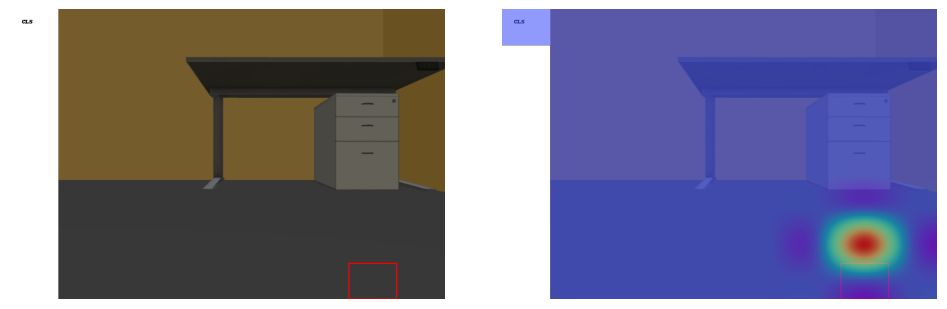

In [8]:
image = Image.open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/{n}.png')
visualize_grid_to_grid_with_cls(attention_maps[maps][0,0,:,:], 63, image)

/tmp/ipykernel_15494/2544214906.py:399: RuntimeWarning: invalid value encountered in divide
  ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')


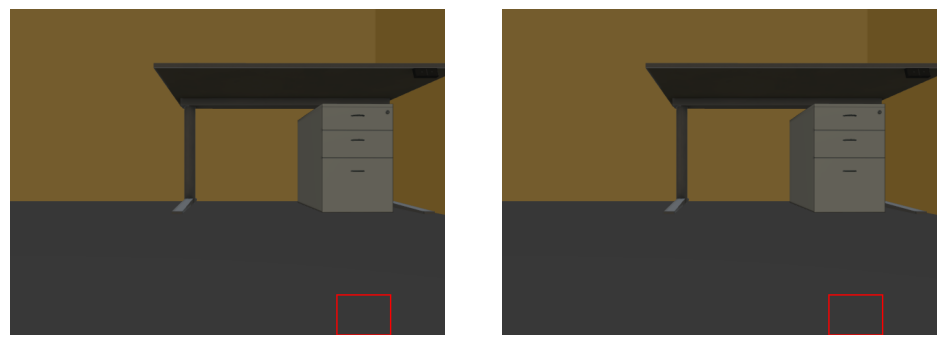

In [9]:
# image = debug_overlay(image, (8,8))
visualize_grid_to_grid(attention_maps[0][0,0,1:,1:], 62, image)

/tmp/ipykernel_15494/2544214906.py:399: RuntimeWarning: invalid value encountered in divide
  ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')


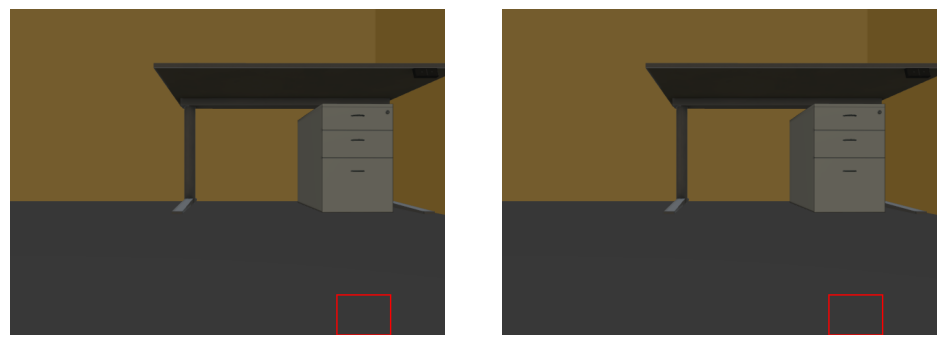

In [10]:
visualize_grid_to_grid(attention_maps[1][0,0,1:,1:], 62, image)

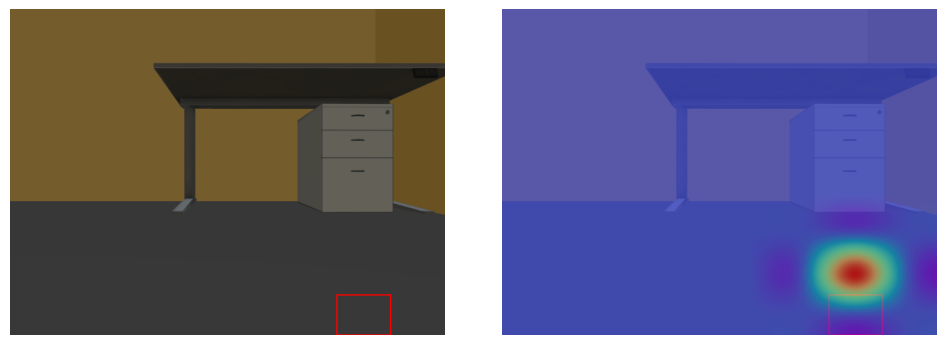

In [11]:
visualize_grid_to_grid(attention_maps[2][0,0,1:,1:], 62, image)

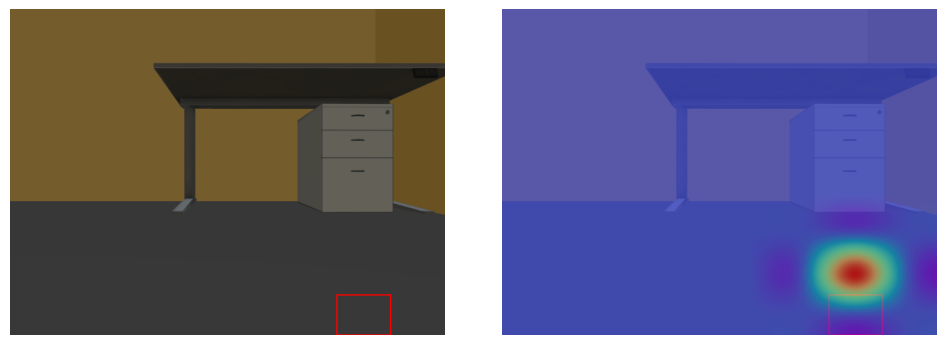

In [12]:
visualize_grid_to_grid(attention_maps[3][0,0,1:,1:], 62, image)

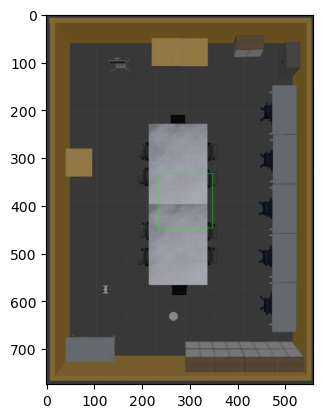

In [13]:
image2 = Image.open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/scene_{goal_des}.png')
plt.imshow(image2)
plt.show()

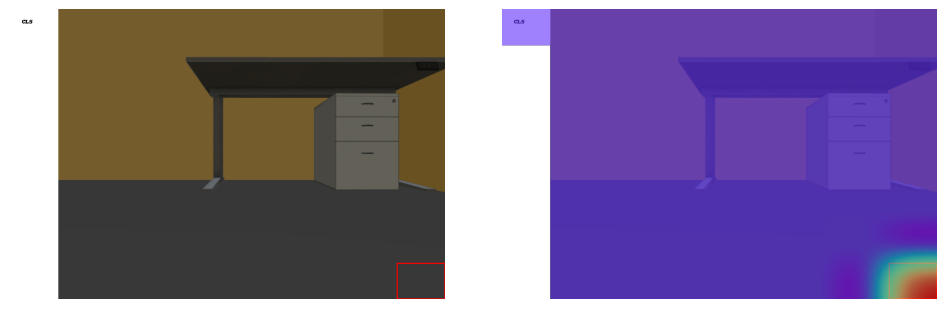

In [14]:
visualize_grid_to_grid_with_cls(attention_maps[maps][0,0,:,:], 64, image)

### Attention map of a single head

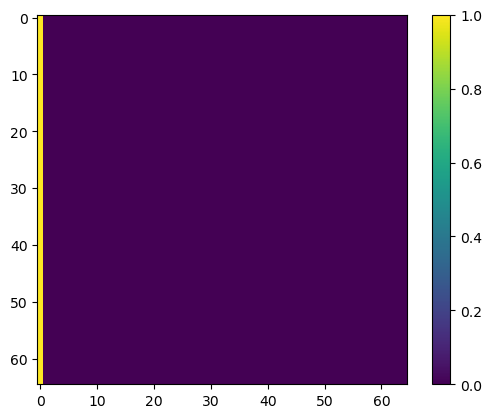

In [17]:
visualize_head(attention_maps[0][0,0])

### Attention maps in layer 1

TypeError: Invalid shape (65,) for image data

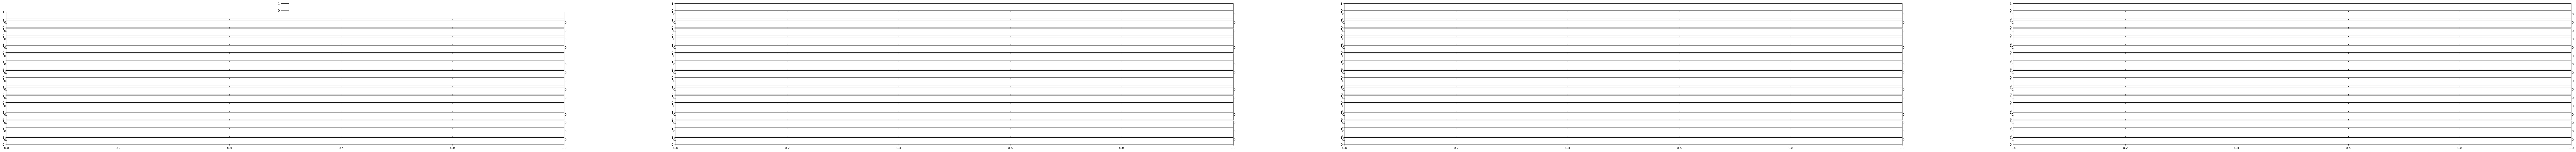

In [18]:
visualize_heads(attention_maps[0], cols=4)

### Attention maps in layer 2

In [ ]:
visualize_heads(attention_maps[1], cols=4)

### Attention maps in layer 3

In [ ]:
visualize_heads(attention_maps[2], cols=4)

In [ ]:
index = mean_shannon_wiener_index(attention_maps)
mean_gini = mean_gini_coefficient(attention_maps)
with open(f'/home/regmed/dregmed/vis_to_nav/metrics_data/{goal_des}/depth_metrics{bh}_{n}.txt', 'a') as f:
  f.write('Mean Shannon-Wiener Index: '+str(index)+'\n')
  f.write('Mean Gini Coefficient: '+str(mean_gini)+'\n')
print(f"Mean Gini Coefficient: {mean_gini}")
print(f"Mean Shannon-Wiener Index: {index}") 

Mean Gini Coefficient: 0.9846153846153847
Mean Shannon-Wiener Index: 6.02236795425415
